## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
    - Research Question
    - Summary
<p></p>
2. Selection of Data 
    - Packages Used
    - Loading and Cleansing
<p></p>
3. Training, Validation, and Testing Sets
    - Compartmentalization
    - Summary Statistics
<p></p>
4. Preprocessing 
    - Indetification of Class Imbalances
    - Balancing Decision
<p></p>
5. Building our Model
    - Overview 
    - Tuning
    - Accuracy Comparison
<p></p>
5. Analysis and Conclusion
---------------------------------------------------------------------------------------------------------

### 1.) Sypnosis: 

##### Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### Overview:
<p></p>
The market utility of social media platforms such as Facebook, which are able to generate mass revenues for cosmetic brands, has been an established and exploited advertising strategy in the digital age (Moro et. al, 2016). The goal of this project is to take a predictive analytical approach to determine which type of Facebook post (i.e., photo, video, status, or link) will engage the most internet-user engagement, determined through variables such as likes, post consumptions, and post total reach. The dataset which will be used for this analysis was acquired through an experimental data mining technique which included scraping data from the Facebook page of an internationally renowned cosmetics company on posts made between January 1st and December 31st (Moro et. al., 2016).
<p></p>
For the methodology, we will use the variables of the continuous numerical variables of total reaches (Lifetime_Post_Total_Reach) and the number of total impressions (Lifetime_Post_Total_Impressions), and the categorical variable of Facebook post (Type). First, we will look at the relationship between these variables in a scatter plot graph that will help us to formulate our hypothesis. Then, as we are trying to predict the type of post that will be the most successful, we will use a K-nearest neighbour classification analysis. To do so, we must determine the K value using cross-validation of the training data. Then, we will need to test the accuracy of the classifier with the testing data.
<p></p>
We expect to find that posts which include media, such as photos and videos, are more likely to engage users than other posts, such as statuses and links. This is based on the assumption that the former types of posts might be more likely to be shared and thus will have more exposure.
It is beneficial for social media platforms to increase user engagement, as this is likely to increase revenue through advertising. Therefore, these findings may be used to choose what type of posts are prioritized to maximize user engagement.
<p></p>
These findings may lead to further exploration of how the contents of these posts impact user engagement. This may include the duration of a video, content of an image, length of a status, or details about the contents of a link. 

---------------------------------------------------------------------------------------------------------

### 2.) Selection of data

#### List of Packages Used

In [11]:
install.packages("caTools")
library(caTools)
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(MASS)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Loading Data and Fixing Column Headers

In [12]:
facebook <- read_csv2("https://raw.githubusercontent.com/calamari99/Facebook-Post-Predictor/main/data/dataset_Facebook.csv")
# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Paid", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers without spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

glimpse(facebook)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Rows: 500
Columns: 19
$ Page_total_likes                                                    <dbl> 1…
$ Type                                                                <fct> P…
$ Category                                                            <fct> 2…
$ Post_Month                                                          <fct> 1…
$ Post_Weekday                                                        <fct> 4…
$ Post_Hour                                                           <fct> 3…
$ Paid                                                                <fct> 0…
$ Lifetime_Post_Total_Reach                                           <dbl> 2…
$ Lifetime_Post_Total_Impressions                                     <dbl> 5…
$ Lifetime_Engaged_Users                                              <dbl> 1…
$ Lifetime_Post_Consumers                                             <dbl> 1…
$ Lifetime_Post_Consumptions                                          <dbl> 1…
$ Lifetime_Post_Impressions_by

##### Let us select only the data values relevant to our case scenario

To specify the best type of post possible and we explore the relationship between the metrics produced by a post and the post type. The following key performance indicators describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above) 

In [13]:
facebook_clean <- dplyr::select(facebook, Type, comment,
                                like, share, Total_Interactions,
                                Paid, Lifetime_Post_Total_Impressions, Lifetime_Post_Total_Reach) %>% na.omit(df)

facebook_clean_unpaid <- facebook_clean %>% filter(Paid == 0)
facebook_clean_paid <- facebook_clean %>% filter(Paid == 1)

unpaid_summary <- facebook_clean_unpaid %>% group_by(Type) %>% 
  summarise(unpaid = n()) 

paid_summary <- facebook_clean_paid %>% group_by(Type) %>% 
  summarise(paid = n())

Reduce(dplyr::full_join, list(unpaid_summary, paid_summary))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "Type"



Type,unpaid,paid
<fct>,<int>,<int>
Link,16,6
Photo,302,119
Status,35,10
Video,3,4


Within our 500 data points collected, we have filtered out all observations with NA values and separated our data into paid and unpaid categories due to additive relationships. This allows us to explore the relationship between post type and our defined success metric. Moving forward, this study will only evaluate on media postings without paid advertising.

> Note: Social media algorithms that adjust prioritizations between paid and non-paid posts can heavily factor into our metrics received and should be considered in this analysis. To control for this potential source of uncertainty, we haved isolated our data into paid and unpaid categories. 

---


### 3.) Training, Validation, and Testing Sets 



#### Compartmentalization
We have split our data into training and testing sets in order to reduce bias within our model data and testing data. 

*Distribution of Training and Testing set*
<br>
Testing set will be 20% of data collected
<br>
Validation set will be 10% of data collected
<br>
Training data set be 70% of data collected

*Cross-validation technique*
<br>
let us split our data into 10 total groups.
<br>
(~25 points tested, 100 points for training)

We chose to approach our training data by creating a 80:20 ratio between testing and training data where the  training set is composed of both the “validation” and “training” set. We have also chosen a 10-fold cross-validation procedure to establish unbiased estimators.

In [14]:
# Defining Variables
set.seed(99)
partitionTrain = 0.8
ratioTrainValidation = 7/8

##### Total Posts:

In [15]:
# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
train_val_data <- subset(facebook_clean, split == TRUE)
test_set <- subset(facebook_clean, split == FALSE)

split <- sample.split(train_val_data$like, SplitRatio = ratioTrainValidation)
train_set <- subset(train_val_data, split == TRUE)
val_set <- subset(train_val_data, split == FALSE)

train_set

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Photo,4,79,17,100,0,5091,2752
Photo,19,325,49,393,0,13594,7244
Photo,3,249,27,279,1,19479,11692
Photo,0,325,14,339,1,24137,13720
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,0,53,22,75,0,6229,3480
Photo,4,93,18,115,0,7216,3778


#### Unpaid Posts:

In [16]:
split <- sample.split(facebook_clean_unpaid$like, SplitRatio = partitionTrain)
train_val_data_unpaid <- subset(facebook_clean_unpaid, split == TRUE)
test_set_unpaid <- subset(facebook_clean_unpaid, split == FALSE)

split <- sample.split(train_val_data_unpaid$like, SplitRatio = ratioTrainValidation)
train_set_unpaid <- subset(train_val_data_unpaid, split == TRUE)
val_set_unpaid <- subset(train_val_data_unpaid, split == FALSE)

#glimpse(train_set_unpaid)
train_set_unpaid

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Status,5,130,29,164,0,19057,10460
Photo,19,325,49,393,0,13594,7244
Status,1,152,33,186,0,20849,10472
Status,0,161,31,192,0,22538,11844
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,17,185,55,257,0,13960,8412
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,4,93,18,115,0,7216,3778



#### Training Data Summaries

- Number of observations of each type
- Mean and Median of key metrics in each post type


##### Summary of Unpaid Posts:

In [17]:
summ_train_unpaid <- train_set_unpaid %>%
    group_by(Type) %>%
        summarise(
        count = n(),
        mean_comment = mean(comment), 
        median_comment = median(comment), 
        mean_like = mean(like),
        median_like = median(like),
        mean_Total_Interactions = mean(Total_Interactions),
        median_Total_Interactions = median(Total_Interactions),
        mean_share = mean(share),
        median_share = median(share),
    )

summ_train_unpaid

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,10,3.100000,1,100.9000,73.5,119.8000,85,15.80000,11
Photo,210,6.404762,2,155.9905,93.0,186.5476,115,24.15238,18
Status,25,6.880000,3,145.8400,129.0,179.4800,164,26.76000,27
Video,3,10.333333,6,216.0000,204.0,285.6667,271,59.33333,44


-----
### 4.) PreProcessing 

#### Indentification of class imbalances
We want to be able to identify possible class imbalances as the KNN-classification model is a lazy learning algorithm. Thus we need to ensure that our data set is balanced. We start by reviewing summary statistics and quickly visualizing the distribution of observations.

In [18]:
summary(train_set_unpaid)

     Type        comment             like            share      
 Link  : 10   Min.   :  0.000   Min.   :   0.0   Min.   :  0.0  
 Photo :210   1st Qu.:  0.750   1st Qu.:  56.0   1st Qu.: 10.0  
 Status: 25   Median :  2.000   Median :  96.0   Median : 18.0  
 Video :  3   Mean   :  6.367   Mean   : 153.5   Mean   : 24.5  
              3rd Qu.:  6.000   3rd Qu.: 180.5   3rd Qu.: 32.0  
              Max.   :146.000   Max.   :1546.0   Max.   :181.0  
 Total_Interactions Paid    Lifetime_Post_Total_Impressions
 Min.   :   0.0     0:248   Min.   :    570                
 1st Qu.:  70.0     1:  0   1st Qu.:   5403                
 Median : 117.0             Median :   8364                
 Mean   : 184.3             Mean   :  28885                
 3rd Qu.: 221.0             3rd Qu.:  17936                
 Max.   :1873.0             Max.   :1110282                
 Lifetime_Post_Total_Reach
 Min.   :   238           
 1st Qu.:  3108           
 Median :  4847           
 Mean   : 11893  

Warning message:
“Removed 211 rows containing missing values (geom_point).”


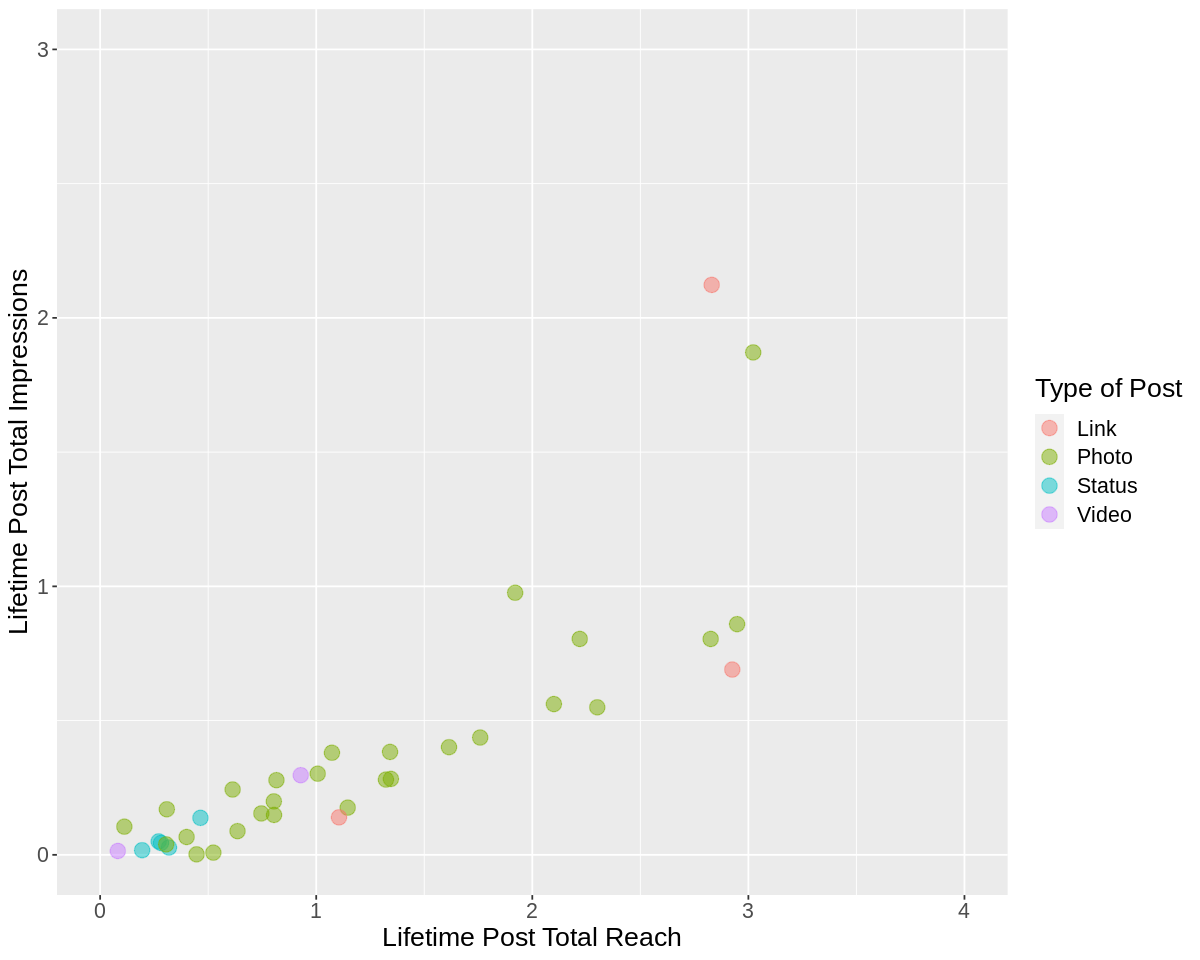

In [19]:
options(repr.plot.width=10, repr.plot.height=8)
test_unpaid_plot <- train_set_unpaid %>% mutate(Lifetime_Post_Total_Reach = scale(Lifetime_Post_Total_Reach),
                                              Lifetime_Post_Total_Impressions = scale(Lifetime_Post_Total_Impressions)) %>% 
    ggplot(aes(x = Lifetime_Post_Total_Reach, y = Lifetime_Post_Total_Impressions, color = Type)) +
    geom_point(alpha = 0.5, size = 4) +
    labs(color = "Type of Post", x = "Lifetime Post Total Reach", y = "Lifetime Post Total Impressions") +
    #xlim(NA, 4) + ylim(NA, 4) +
    scale_x_continuous(limits=c(0, 4)) +
    scale_y_continuous(limits=c(0, 3)) +
    theme(text = element_text(size = 16))

test_unpaid_plot

#### Balancing Decision
We see the distribution of the type of posts is not equal so we should consider balancing. However, this introduces potential complications in further parts of our analysis, mainly the cross validation step. We find that balancing our data in this part of our analysis results in overestimated accuracies for our cross validation model later on. Additionally, we are hestitant to balance training set because this alternation is not reflected in our testing set, which can lead to more uncertainty. Because of these factors, we chose to leave our data unbalanced. We believe this will lead to less biased results when using our training data set further in our report. 

### 5.) Building our Model

#### Overview
We use the original training data into our tuning selection process. Then by scaling the data and following the tidymodel recipes workflow, we collect the results from various values of k. Our base value of k is set to 3.

In [35]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")

unpaid_recipe <- recipe(Type ~ 
                        Lifetime_Post_Total_Reach + Lifetime_Post_Total_Impressions,
                        data = train_set_unpaid) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

unpaid_fit <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      # fit(data = upsampled_cancer)
      fit(data = train_set_unpaid)

      #fit_resamples(resamples = unpaid_vfold)

unpaid_val_predicted <- predict(unpaid_fit, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy <- unpaid_val_predicted %>%
    metrics(truth = Type, estimate = .pred_class)
    
unpaid_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.75000000
kap,multiclass,0.06896552


We found that our current accuracy against our validation set is roughly 75%. We will continue to tune our model in the following steps.

#### Tuning our model

1. We will perform the cross validation technique with 10 folds to account for randomness.

In [38]:
set.seed(99)
#unpaid_vfold <- vfold_cv(upsampled_cancer, v = 10, strata = Type)
unpaid_vfold <- vfold_cv(train_set_unpaid, v = 10, strata = Type)

unpaid_fit_v2 <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = unpaid_vfold) %>% collect_metrics()
unpaid_fit_v2

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.8590000,10,0.02409074
roc_auc,hand_till,0.7702354,10,0.04136906


We see the accuracy of our model is around 86%.

2. Next we will perform a paramterization selection method to select a better value for K.

In [39]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_results <- workflow() %>%
  add_recipe(unpaid_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = unpaid_vfold, grid = 10) %>% 
  collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracies

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8511667,10,0.02721894,Model1
3,accuracy,multiclass,0.8590000,10,0.02409074,Model2
4,accuracy,multiclass,0.8631667,10,0.02451786,Model3
6,accuracy,multiclass,0.8434744,10,0.02435619,Model4
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,accuracy,multiclass,0.8433205,10,0.02381319,Model6
10,accuracy,multiclass,0.8513333,10,0.02558478,Model7
12,accuracy,multiclass,0.8551795,10,0.02303849,Model8
14,accuracy,multiclass,0.8591795,10,0.02309284,Model9


3. Then using our collected metrics, we can visualize our accuracies to refine our value of K.

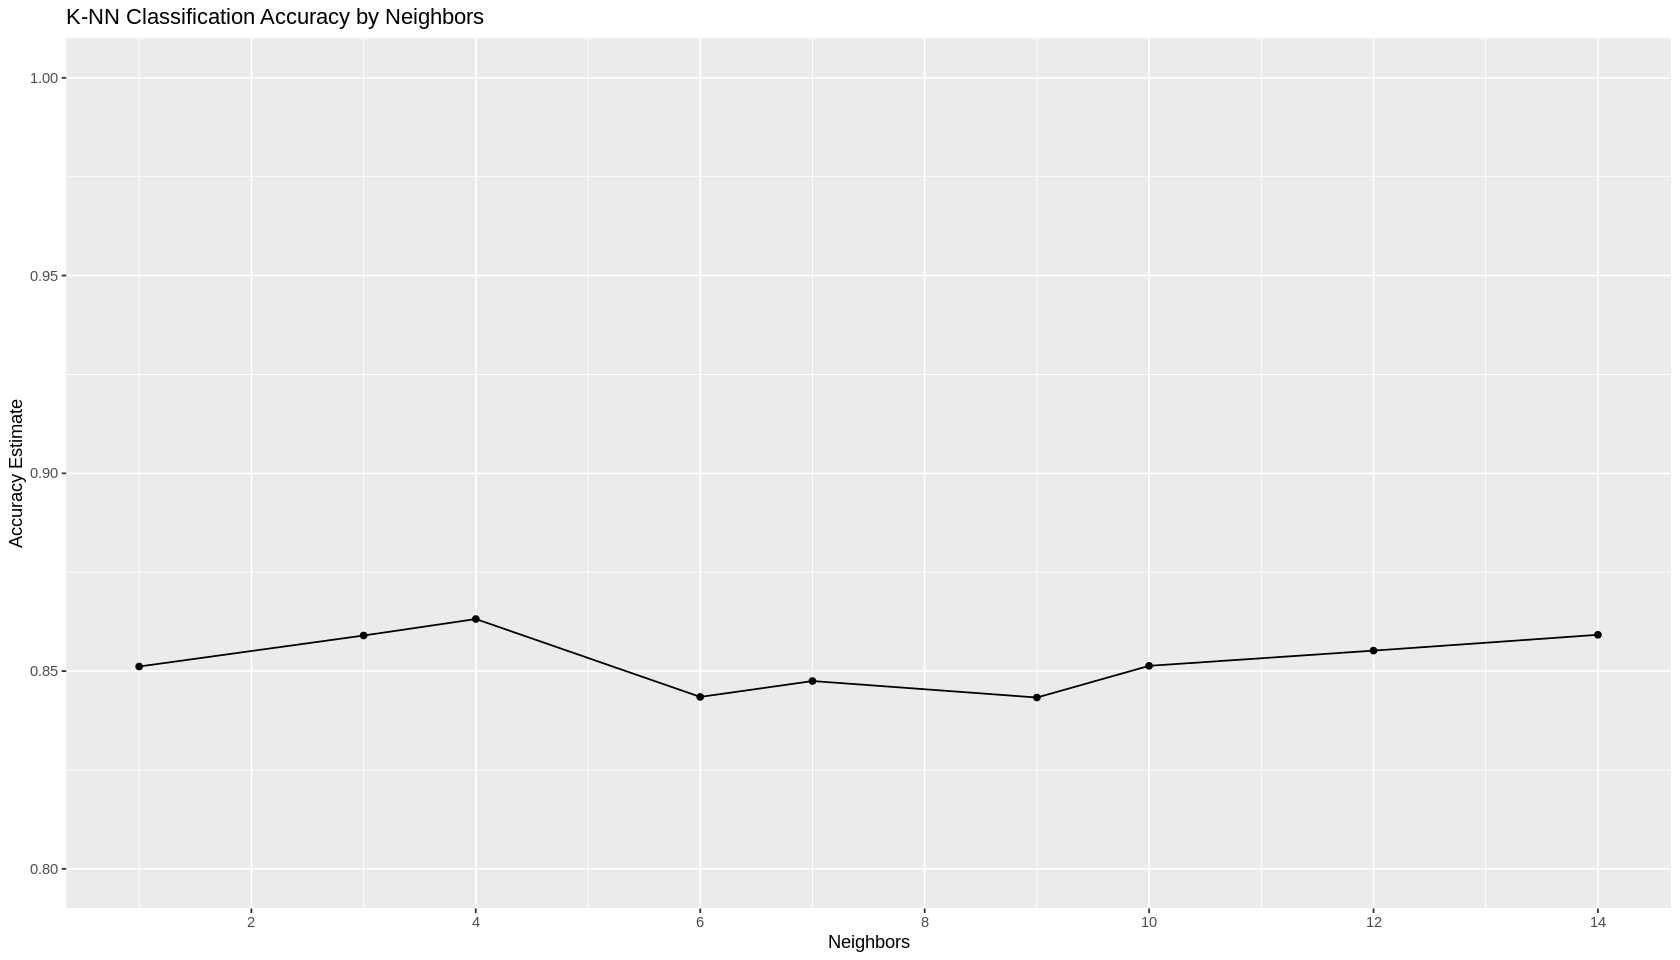

In [40]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "K-NN Classification Accuracy by Neighbors") +
      scale_x_continuous(breaks = seq(0, 16, by = 2)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [41]:
most_accurate_k <- knn_results %>% filter(.metric == "accuracy") %>% arrange(desc(mean)) %>% slice(1)
most_accurate_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,accuracy,multiclass,0.8631667,10,0.02451786,Model3


The visualization suggests that K=4 averages the highest accuracy of ~86% from our 10 cross validation sets. We edit our model specification to take k=2 instead of k=3 as follows. After doing so, we can compare the accuracy of each model.

In [42]:
# we use the same recipe, change spec

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
  set_engine("kknn") %>%
  set_mode("classification")

unpaid_fit_tuned <- workflow() %>%
      add_recipe(unpaid_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = train_set_unpaid) 
      #fit_resamples(resamples = unpaid_vfold)

unpaid_val_predicted_tuned <- predict(unpaid_fit_tuned, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy_tuned <- unpaid_val_predicted_tuned %>%
    metrics(truth = Type, estimate = .pred_class) %>% filter(.metric == "accuracy")

model_improvement <- unpaid_prediction_accuracy_tuned$.estimate - unpaid_prediction_accuracy$.estimate

unpaid_prediction_accuracy_tuned
print(model_improvement)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.75


[1] 0.0000000 0.6810345


After changing our model spec from 2 to 3, we see that the modifications to our model has increased our accuracy by roughly *5.56%* (our original accuracy was roughly *72.2%*) and thus we will choose the tuned model.

#### Accuracy Comparison
- We have limited video observation in our testing set
- after we have classified the limited video observations, any prediction that classifies a video is incorrect
- todo


---------------------------------------------------------------------------------------------------------

### Additional Exploratory Analysis

In [27]:
mean_comment <- summ_train_unpaid$mean_comment
mean_like <- summ_train_unpaid$mean_like
mean_Total_Interactions <- summ_train_unpaid$mean_Total_Interactions
mean_share <- summ_train_unpaid$mean_share
type <- summ_train_unpaid$Type

test_df <- data.frame(mean_comment,mean_like,mean_Total_Interactions,mean_share,type)
test_df

fb_long <- test_df %>%
gather("Stat", "Value", -type)

fb_long


mean_comment,mean_like,mean_Total_Interactions,mean_share,type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.100000,100.9000,119.8000,15.80000,Link
6.404762,155.9905,186.5476,24.15238,Photo
6.880000,145.8400,179.4800,26.76000,Status
10.333333,216.0000,285.6667,59.33333,Video


type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_comment,3.100000
Photo,mean_comment,6.404762
Status,mean_comment,6.880000
Video,mean_comment,10.333333
⋮,⋮,⋮
Link,mean_share,15.80000
Photo,mean_share,24.15238
Status,mean_share,26.76000
Video,mean_share,59.33333


In [28]:
# test_df <- data.frame(
# mean_comment = c(4.0, 7.317073, 13.166667, 12.333333),
# mean_like = c(56.66667, 202.14634, 281.16667, 276.33333),
# mean_Total_Interactions = c(71.0000, 235.2683, 353.8333, 346.6667),
# mean_share = c(10.33333, 25.80488, 59.50000, 58.00000),
# type = c("Link", "Photo", "Status", "Video"))


# fb_long <- test_df %>%
# gather("Stat", "Value", -type)

# fb_long


In [29]:
filter_mean_like <- fb_long %>%
    filter(Stat == "mean_like")

filter_mean_like

type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_like,100.9000
Photo,mean_like,155.9905
Status,mean_like,145.8400
Video,mean_like,216.0000


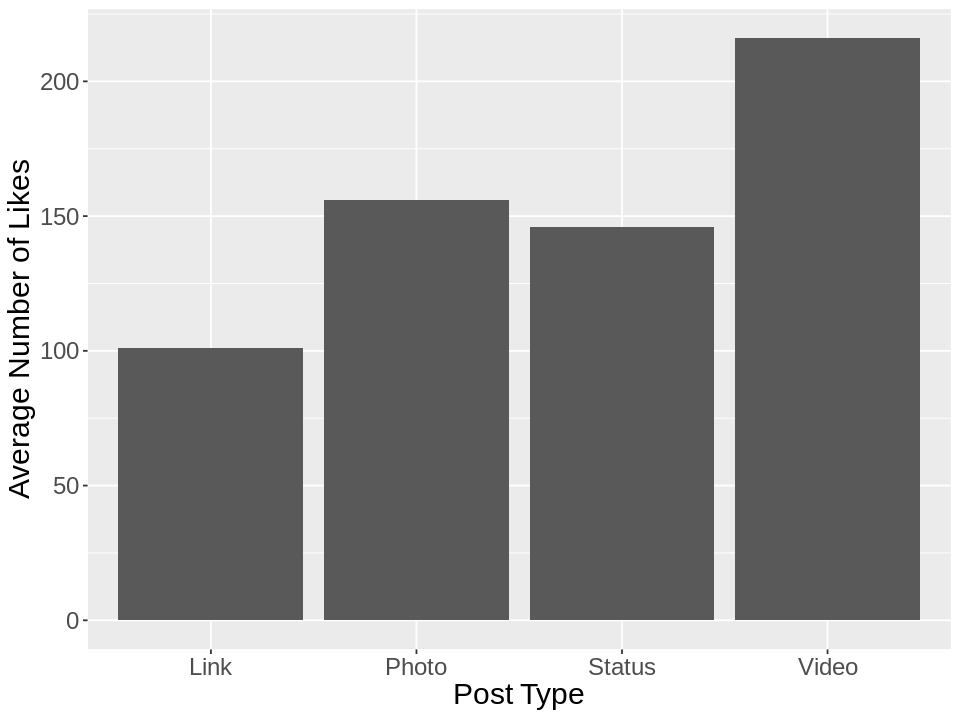

In [30]:
options(repr.plot.width = 8, repr.plot.height = 6) 

mean_likes_bar <- ggplot(filter_mean_like, aes(x = type, y = Value)) +
    geom_bar(stat = "identity") +
    labs(x = "Post Type", y = "Average Number of Likes") +
    theme(text = element_text(size = 18)) 

mean_likes_bar

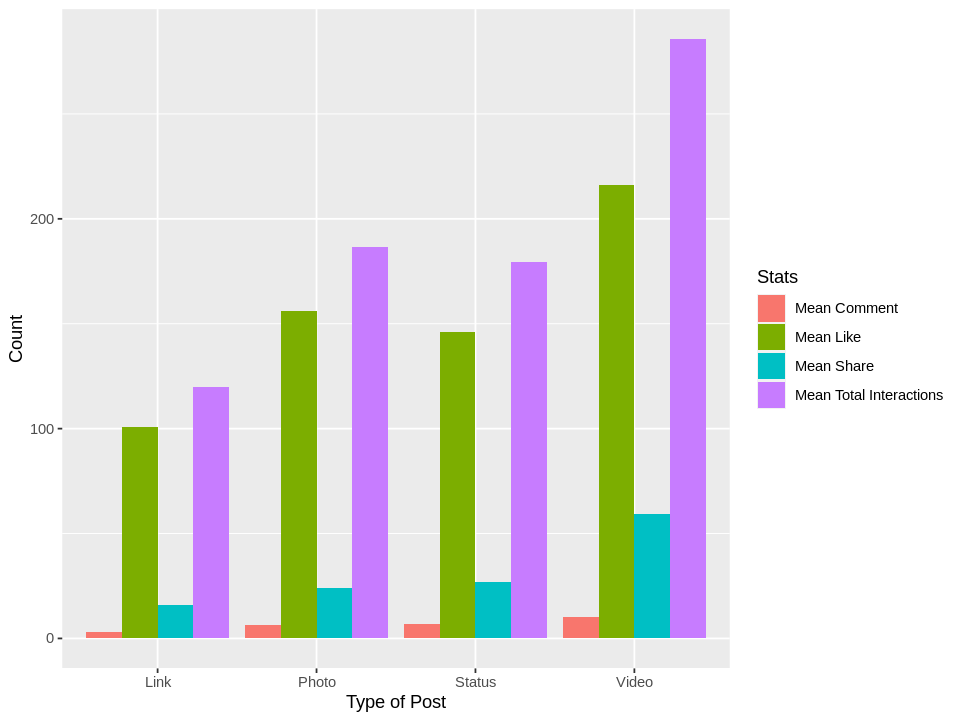

In [31]:
mean_fb <- ggplot(fb_long, aes(x = type, y = Value, fill = Stat)) +
    geom_col(position = "dodge") +
    labs(x = "Type of Post", y = "Count") +
    scale_fill_discrete(name = "Stats", labels = c("Mean Comment", "Mean Like", "Mean Share", "Mean Total Interactions"))

mean_fb

Warning message:
“Removed 21 rows containing missing values (geom_point).”


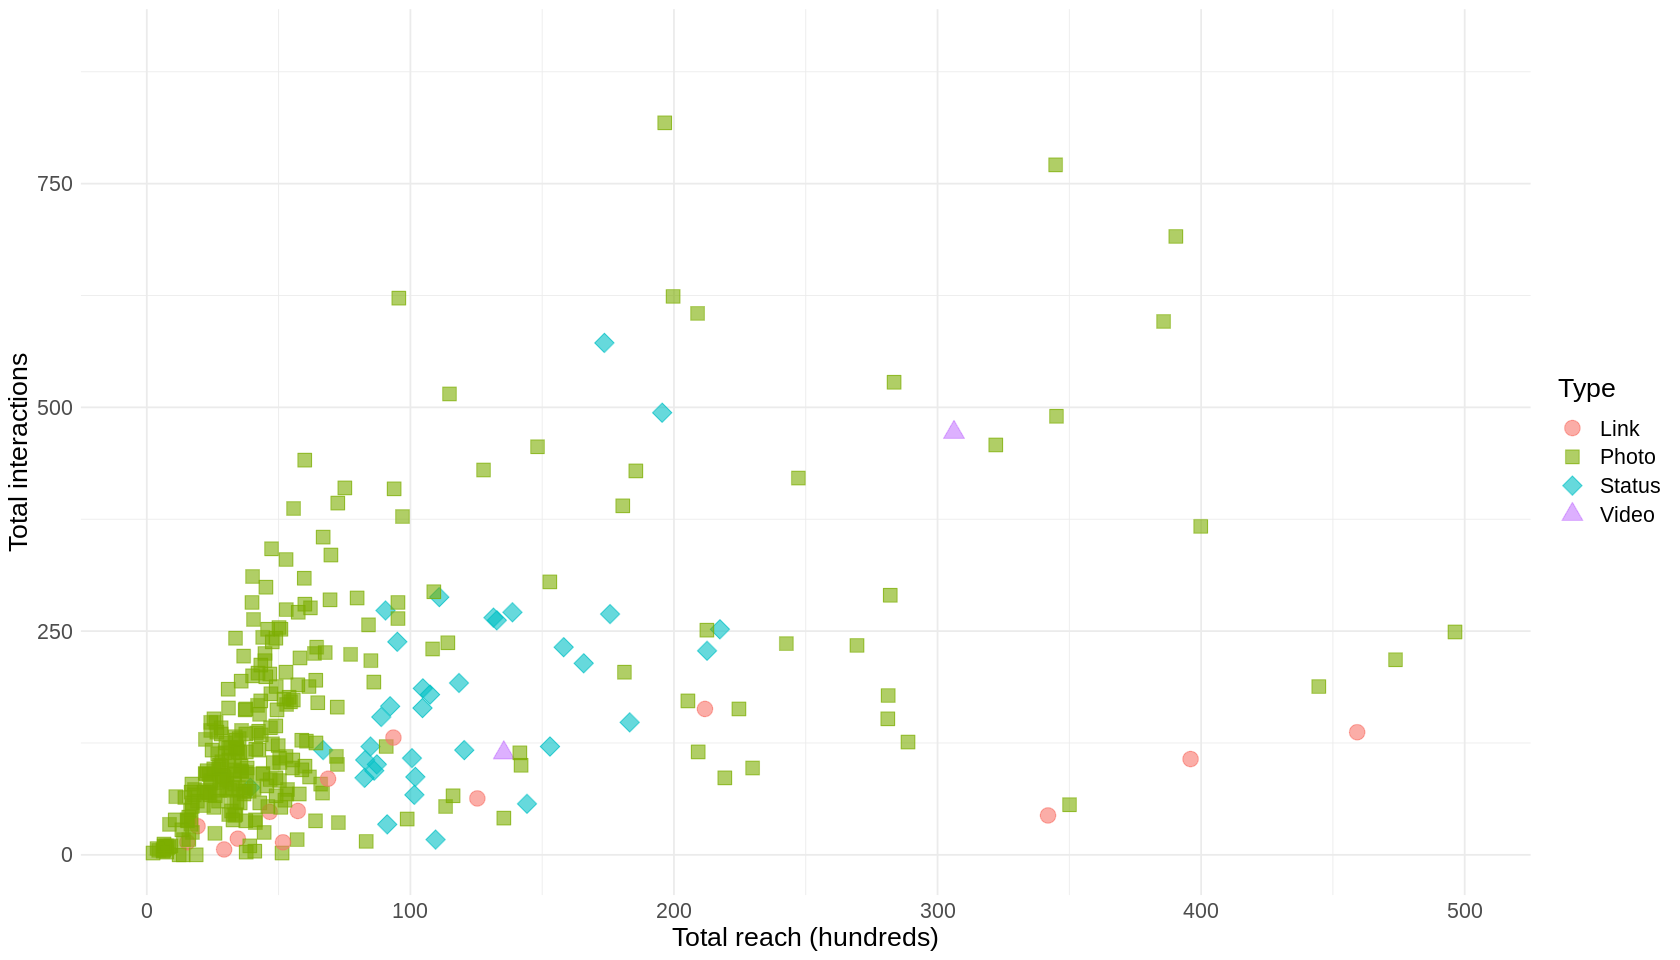

In [32]:
library(ggplot2)
unpaid_plot <- facebook_clean_unpaid %>% 
    ggplot(aes(x = Lifetime_Post_Total_Reach/100, y = Total_Interactions, shape=Type, color=Type, fill=Type))+
    geom_point(alpha=0.6, size=4)+
    labs(x="Total reach (hundreds)", y="Total interactions", group="Type")+
    scale_y_continuous(limits = c(0,900))+
    scale_x_continuous(limits = c(0,500))+
    scale_shape_manual(values = c(21,22,23,24)) +
    scale_size_manual(values=c(1,6,7,9))+
    theme_minimal()+
    theme(text = element_text(size = 16))
    options(repr.plot.width =14, repr.plot.height = 8) 
unpaid_plot

### Bibliography

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research. 69(9), 3341 - 3351. 

In [33]:
facebook

Page_total_likes,Type,Category,Post_Month,Post_Weekday,Post_Hour,Paid,Lifetime_Post_Total_Reach,Lifetime_Post_Total_Impressions,Lifetime_Engaged_Users,Lifetime_Post_Consumers,Lifetime_Post_Consumptions,Lifetime_Post_Impressions_by_people_who_have_liked_your_Page,Lifetime_Post_reach_by_people_who_like_your_Page,Lifetime_People_who_have_liked_your_Page_and_engaged_with_your_post,comment,like,share,Total_Interactions
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119
